# Poking at US Drinking Water Violations data from SWDIS

In this exercise, I analyze US Public Water System's (USPWS) Violation data from EPA accessed using its Envirofacts Data Service API to try to explore the following ...

1. Number of all and health-based violations.
2. Number of active public water systems (PWS), percentage with violations.
3. Violation trends by year.
4. Identify key violation types that contribute to the trend(s).
5. Violation distributions by PWS.
6. Violation distributions by location (county).
7. Number of people affected by these violations.
8. Based on the above, identify potential further exploration areas.

In [1]:
# disable auto-scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# setup environment
import numpy as np
import pandas as pd
import requests
import csv
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import mapclassify

# plot settings
plt_params = {'figure.figsize': (15, 8),
    'figure.titlesize': 16,
    'legend.fontsize': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12}
plt.rcParams.update(plt_params)

## A. Fetch data from Violation and Water System tables

In [4]:
%%time
# Data provided by https://www.epa.gov/enviro/sdwis-model via
# RESTful data service API which allows query through the use of a URL
# Here we access the VIOLATION table from rows 0-1000000 in a csv format
url = "https://data.epa.gov/efservice/VIOLATION/ROWS/0:9999999/CSV"

with requests.Session() as s:
    print(f"EPA SWDIS, VIOLATION, accessed: {dt.datetime.now()}")
    viol = s.get(url).content.decode('utf-8')
    viol = csv.reader(viol.splitlines(), delimiter=',')
    viol = list(viol)

# dataframe
viol = pd.DataFrame(viol)
viol.head()

EPA SWDIS, VIOLATION, accessed: 2021-02-07 05:14:54.000354
CPU times: user 38 s, sys: 6.05 s, total: 44 s
Wall time: 2min 32s


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,VIOLATION.PWSID,VIOLATION.VIOLATION_ID,VIOLATION.FACILITY_ID,VIOLATION.POPULATION_SERVED_COUNT,VIOLATION.NPM_CANDIDATE,VIOLATION.PWS_ACTIVITY_CODE,VIOLATION.PWS_DEACTIVATION_DATE,VIOLATION.PRIMARY_SOURCE_CODE,VIOLATION.POP_CAT_5_CODE,VIOLATION.PRIMACY_AGENCY_CODE,...,VIOLATION.RTC_ENFORCEMENT_ID,VIOLATION.RTC_DATE,VIOLATION.PUBLIC_NOTIFICATION_TIER,VIOLATION.ORIGINATOR_CODE,VIOLATION.SAMPLE_RESULT_ID,VIOLATION.CORRECTIVE_ACTION_ID,VIOLATION.RULE_CODE,VIOLATION.RULE_GROUP_CODE,VIOLATION.RULE_FAMILY_CODE,
1,WA5357776,10418782983,002,2103,N,A,,GW,2,WA,...,841878ENF,11-AUG-11,3,S,,,310,300,310,None
2,WA5357776,10431882050,001,2103,N,A,,GW,2,WA,...,843188ENF,11-AUG-11,3,S,,,320,300,320,None
3,WA5359350,19172332969,33451,2140,Y,A,,GW,2,WA,...,2417233ENF,17-OCT-19,3,S,,,310,300,310,None
4,WA5359350,19206721036,21043,2140,Y,A,,GW,2,WA,...,,,3,S,,,333,300,330,None


In [5]:
%%time
# Data provided by https://www.epa.gov/enviro/sdwis-model via
# RESTful data service API which allows query through the use of a URL
# Here we access the WATER_SYSTEM table from rows 0-750000 in a csv format
pws_url = "https://data.epa.gov/efservice/WATER_SYSTEM/ROWS/0:750000/CSV"

with requests.Session() as s:
    print(f"EPA SWDIS, WATER_SYSTEM, accessed: {dt.datetime.now()}")
    pws = s.get(pws_url).content.decode('utf-8')
    pws = csv.reader(pws.splitlines(), delimiter=',')
    pws = list(pws)

# dataframe
pws = pd.DataFrame(pws)
pws.head()

EPA SWDIS, WATER_SYSTEM, accessed: 2021-02-07 05:17:26.193614
CPU times: user 9.95 s, sys: 1.39 s, total: 11.3 s
Wall time: 49.9 s


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,WATER_SYSTEM.PWSID,WATER_SYSTEM.PWS_NAME,WATER_SYSTEM.NPM_CANDIDATE,WATER_SYSTEM.PRIMACY_AGENCY_CODE,WATER_SYSTEM.EPA_REGION,WATER_SYSTEM.SEASON_BEGIN_DATE,WATER_SYSTEM.SEASON_END_DATE,WATER_SYSTEM.PWS_ACTIVITY_CODE,WATER_SYSTEM.PWS_DEACTIVATION_DATE,WATER_SYSTEM.PWS_TYPE_CODE,...,WATER_SYSTEM.ZIP_CODE,WATER_SYSTEM.COUNTRY_CODE,WATER_SYSTEM.STATE_CODE,WATER_SYSTEM.SOURCE_WATER_PROTECTION_CODE,WATER_SYSTEM.SOURCE_PROTECTION_BEGIN_DATE,WATER_SYSTEM.OUTSTANDING_PERFORMER,WATER_SYSTEM.OUTSTANDING_PERFORM_BEGIN_DATE,WATER_SYSTEM.CITIES_SERVED,WATER_SYSTEM.COUNTIES_SERVED,
1,MI2021818,CENTRAL MI MENTAL HEALTH CLINIC,Y,MI,05,01-01,12-31,A,,NTNCWS,...,48858,US,MI,,,,,Not Reported,Clare,None
2,MI2008361,GRANNY'S GRIDDLE,Y,MI,05,01-01,12-31,A,,TNCWS,...,49442,US,MI,,,,,Not Reported,Muskegon,None
3,MI2030530,RAYBA'S TENNIS RETREAT,Y,MI,05,01-01,12-31,A,,TNCWS,...,49247,US,MI,,,,,Not Reported,Hillsdale,None
4,MI2031475,KLINGER LAKE TRADING POST,Y,MI,05,01-01,12-31,A,,TNCWS,...,49091,US,MI,,,,,Not Reported,St. Joseph,None


## B. Process data

In [6]:
# fetched data is from violation and water_system tables, therefore ...
# clean header by removing the VIOLATION and WATER_SYSTEM prefixs
# from the columns

header_viol = viol.iloc[0].str.split('.').str[1]
header_pws = pws.iloc[0].str.split('.').str[1]

# clean dataframes

# slice out headers
viol = viol[1:] 
pws = pws[1:] 

# rename columns
viol.columns = header_viol # column names
pws.columns = header_pws # column names

# remove empty columns ("NaN": None)
viol = viol.dropna(axis=1, how="all") 
pws = pws.dropna(axis=1, how="all") 

In [7]:
# keep select columns
viol = viol[['PWSID', 'VIOLATION_ID', 'FACILITY_ID',
         'POPULATION_SERVED_COUNT', 'PWS_ACTIVITY_CODE',
         "PRIMACY_AGENCY_CODE", 'PWS_DEACTIVATION_DATE',
         'VIOLATION_CATEGORY_CODE', 'IS_HEALTH_BASED_IND',
         'CONTAMINANT_CODE', 'COMPL_PER_BEGIN_DATE']]

pws = pws[['PWSID', 'PWS_NAME', 
       'PWS_ACTIVITY_CODE', 'PWS_DEACTIVATION_DATE', 'PWS_TYPE_CODE',
       'POPULATION_SERVED_COUNT',
       'PRIMARY_SOURCE_CODE',
       'ZIP_CODE', 'STATE_CODE', 'COUNTIES_SERVED']]

### B.1. Filter data for years 2000-2019

In [8]:
# COMPL_PER_BEGIN_DATE: Compliance Period Begin Date - represents 
# the beginning of a period of time when a public water system
# was in violation of a primary drinking water regulation.
# This may also be the date when the public water system missed a
# monitoring event or the date when the public water system failed
# to complete a required action (for example, failing to install new
# treatment technology by a required date).

# filter violation data for years 2000-2019
viol["COMPL_PER_BEGIN_DATE"] = pd.to_datetime(viol["COMPL_PER_BEGIN_DATE"])

# violation begin year as a new column
#viol["BEGIN_YEAR"] = viol["COMPL_PER_BEGIN_DATE"].dt.year
viol["BEGIN_YEAR"] = viol["COMPL_PER_BEGIN_DATE"].dt.year.astype('Int64')

# population as integer
viol["POPULATION_SERVED_COUNT"] = viol["POPULATION_SERVED_COUNT"].astype(int)

# delete now redundant COMPL_PER_BEGIN_DATE column
viol.drop(["COMPL_PER_BEGIN_DATE"], axis=1, inplace=True)

# Lets check the begin year for the violations
#print("Years Before data clean: ", set(viol["BEGIN_YEAR"]))
# clearly the there are some years in the future (errors? typos?)

# lets remove data associated with the (errorsome?) future years
viol = viol.loc[viol["BEGIN_YEAR"] <= 2019] # removed 2020 too, too recent

# lets also remove data from the 1900's
viol = viol.loc[viol["BEGIN_YEAR"] >= 2000] # removed data from 1900's

print("\nYears: ", set(viol["BEGIN_YEAR"]))


Years:  {2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019}


In [9]:
# filter only the active water systems in 2000-2019
# convert PWS_DEACTIVATION_DATE to datetime type
pws["PWS_DEACTIVATION_DATE"] = pd.to_datetime(
    pws["PWS_DEACTIVATION_DATE"])

# filter water systems either active ...
# or if deactive, deactive before 2000-begin or after 2019-end
pws = pws[(pws["PWS_ACTIVITY_CODE"] == "A")
                | ((pws["PWS_DEACTIVATION_DATE"] <= "1999-12-31")
                    | (pws["PWS_DEACTIVATION_DATE"] <= "2019-12-31"))]

In [10]:
# verify PWSIDs are unique

n_PWSIDs = len(pws["PWSID"])
n_PWSIDs_unique = pws["PWSID"].nunique()

assert(n_PWSIDs_unique == n_PWSIDs)

### B.2. Filter data for mainland US

In [11]:
# US mainland states/district FIPS: postal codes ...
FIPS = {
    "09": "CT", "23": "ME", "25": "MA",
    "33": "NH", "44": "RI", "50": "VT",
    "34": "NJ", "36": "NY", "42": "PA",
    "17": "IL", "18": "IN", "26": "MI",
    "39": "OH", "55": "WI", "19": "IA",
    "20": "KS", "27": "MN", "29": "MO",
    "31": "NE", "38": "ND", "46": "SD",
    "10": "DE", "11": "DC", "12": "FL",
    "13": "GA", "24": "MD", "37": "NC",
    "45": "SC", "51": "VA", "54": "WV",
    "01": "AL", "21": "KY", "28": "MS",
    "47": "TN", "05": "AR", "22": "LA",
    "40": "OK", "48": "TX", "04": "AZ",
    "08": "CO", "16": "ID", "30": "MT",
    "32": "NV", "35": "NM", "49": "UT",
    "56": "WY", "06": "CA", "41": "OR",
    "53": "WA"
}

# Exculdedes ...
#   Alaska, Hawaii, American Samoa, Guam, ...
#   Northern Mariana Islands, Puerto Rico, ...
#   Virgin Islands

# list of USPS state abbreviations (mainland)
usps_st = list(FIPS.values())

In [12]:
# filter data from pws within mainland US
pws = pws[pws["STATE_CODE"].isin(usps_st)]

In [13]:
# reset indexes
viol.reset_index(inplace=True, drop=True)
pws.reset_index(inplace=True, drop=True)

In [14]:
viol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999602 entries, 0 to 1999601
Data columns (total 11 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   PWSID                    object
 1   VIOLATION_ID             object
 2   FACILITY_ID              object
 3   POPULATION_SERVED_COUNT  int64 
 4   PWS_ACTIVITY_CODE        object
 5   PRIMACY_AGENCY_CODE      object
 6   PWS_DEACTIVATION_DATE    object
 7   VIOLATION_CATEGORY_CODE  object
 8   IS_HEALTH_BASED_IND      object
 9   CONTAMINANT_CODE         object
 10  BEGIN_YEAR               Int64 
dtypes: Int64(1), int64(1), object(9)
memory usage: 169.7+ MB


In [15]:
pws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408754 entries, 0 to 408753
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   PWSID                    408754 non-null  object        
 1   PWS_NAME                 408754 non-null  object        
 2   PWS_ACTIVITY_CODE        408754 non-null  object        
 3   PWS_DEACTIVATION_DATE    265686 non-null  datetime64[ns]
 4   PWS_TYPE_CODE            408754 non-null  object        
 5   POPULATION_SERVED_COUNT  408754 non-null  object        
 6   PRIMARY_SOURCE_CODE      408754 non-null  object        
 7   ZIP_CODE                 408754 non-null  object        
 8   STATE_CODE               408754 non-null  object        
 9   COUNTIES_SERVED          408754 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 31.2+ MB


In [16]:
# check/verify if there are any duplicate rows

print(f"viol, pws shape: {viol.shape}, {pws.shape}")

# remove redundant rows
viol = viol.drop_duplicates(keep="last")
pws = pws.drop_duplicates(keep="last")

print(f"viol, pws shape (post duplicate removal): {viol.shape}, {pws.shape}")

# shapes didn't change indicates no duplicates were present

viol, pws shape: (1999602, 11), (408754, 10)
viol, pws shape (post duplicate removal): (1999602, 11), (408754, 10)


In [17]:
# check/verify the PWSID and VIOLATION_ID combination is unique
sum(viol.duplicated(subset=["PWSID", "VIOLATION_ID"]))
# return 0 means unique

0

### B.3. Merge viol and pws dataframes with select columns

In [18]:
# merge select columns from violation and water_system tables
# categorize by PWS id

pws_viol = pd.merge(
    viol[["PWSID", "VIOLATION_ID", "BEGIN_YEAR",
          "VIOLATION_CATEGORY_CODE", "IS_HEALTH_BASED_IND"]],
    pws[["PWSID", "PWS_NAME", "STATE_CODE", "ZIP_CODE",
     "POPULATION_SERVED_COUNT"]],
    how="right", on=["PWSID"])

pws_viol.rename(columns={'IS_HEALTH_BASED_IND': "VIOL_HLTH",
                            "POPULATION_SERVED_COUNT": "POPULATION"},
                   inplace=True)

# keep only first five digits of zip code to be consistent
pws_viol["ZIP_CODE"] = pws_viol["ZIP_CODE"].str.slice(stop=5)

pws_viol.head()

,PWSID,VIOLATION_ID,BEGIN_YEAR,VIOLATION_CATEGORY_CODE,VIOL_HLTH,PWS_NAME,STATE_CODE,ZIP_CODE,POPULATION
0,MI2021818,1610040,2015,MCL,Y,CENTRAL MI MENTAL HEALTH CLINIC,MI,48858,65
1,MI2008361,1910491,2018,MON,N,GRANNY'S GRIDDLE,MI,49442,150
2,MI2008361,1510857,2014,MR,N,GRANNY'S GRIDDLE,MI,49442,150
3,MI2008361,1411750,2011,MR,N,GRANNY'S GRIDDLE,MI,49442,150
4,MI2008361,1910389,2018,MR,N,GRANNY'S GRIDDLE,MI,49442,150


In [19]:
pws_viol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138177 entries, 0 to 2138176
Data columns (total 9 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   PWSID                    object
 1   VIOLATION_ID             object
 2   BEGIN_YEAR               Int64 
 3   VIOLATION_CATEGORY_CODE  object
 4   VIOL_HLTH                object
 5   PWS_NAME                 object
 6   STATE_CODE               object
 7   ZIP_CODE                 object
 8   POPULATION               object
dtypes: Int64(1), object(8)
memory usage: 165.2+ MB


In [20]:
# check rows with NaN after merge
pws_viol.isnull().sum()
# non-zero counts for PWS without violations

0
PWSID                           0
VIOLATION_ID               276843
BEGIN_YEAR                 276843
VIOLATION_CATEGORY_CODE    276843
VIOL_HLTH                  276843
PWS_NAME                        0
STATE_CODE                      0
ZIP_CODE                        0
POPULATION                      0
dtype: int64

In [21]:
# count of all and health-based Violations
n_viol = pws_viol["VIOL_HLTH"].count() # all not-null
n_viol_hlth = pws_viol[(pws_viol["VIOL_HLTH"] == "Y")]["VIOL_HLTH"].count()

print(f"# of all violations: {n_viol}")
print(f"# of violations (health-based): {n_viol_hlth},",
     f"{100 * n_viol_hlth / n_viol: .1f}%\n")

# count of PWS's with and without violation 
n_pws = pws_viol["PWSID"].nunique()
n_pws_clean = pws_viol[ # null values
    pws_viol["VIOLATION_ID"].isnull()]["PWSID"].nunique()
n_pws_viol = pws_viol[
    ~pws_viol["VIOLATION_ID"].isnull()]["PWSID"].nunique()
n_pws_viol2 = n_pws - n_pws_clean
assert(n_pws_viol == n_pws_viol2)

n_pws_viol_hlth = pws_viol[(
    pws_viol["VIOL_HLTH"] == "Y")]["PWSID"].nunique()

print(f"# of pws (all active): {n_pws}")
print(f"# of pws (w/ violations): {n_pws_viol},",
      f"{100 * n_pws_viol / n_pws : .1f}%")
print(f"# of pws (w/ health-based violations): {n_pws_viol_hlth},",
      f"{100 * n_pws_viol_hlth / n_pws : .1f}%")
print(f"# of pws (wo/ violations): {n_pws_clean},",
      f"{100 * n_pws_clean / n_pws : .1f}%")

# of all violations: 1861334
# of violations (health-based): 204514,  11.0%

# of pws (all active): 408754
# of pws (w/ violations): 131911,  32.3%
# of pws (w/ health-based violations): 51418,  12.6%
# of pws (wo/ violations): 276843,  67.7%


## 1. Number of all and health-based violations

For the years 2000-2019, there were 1,861,334 total violations of which 204,514 (11.0%) were health-based.

## 2. Number of active PWS with violations.

Among the 408,754 active PWS's, 131,911 (32.3%) of them had one or more violations -- of these, 51,418 of them had one or more health-based violations (40.0% of PWS's with violations and 12.6% of all PWS's). 276,843 (67.7%) PWS's did not have any violations in those 20 years.

### B.4. Pickle dataframes for another session

In [22]:
# pickle dataframes for easier access later

# name dataframes
viol.name = "viol"
pws.name = "pws"
pws_viol.name = "pws_viol"

for df in [viol, pws, pws_viol]:
    df.to_pickle(f"./data/{df.name}.pkl")

In [23]:
#raise SystemExit("Break session !!")

### B.5. Coming back in another session

In [24]:
# re-setup environment and load back pws_viol dataframe
pws_viol = pd.read_pickle("./data/pws_viol.pkl")
# population as integer
pws_viol["POPULATION"] = pws_viol["POPULATION"].astype(int)
#pws_viol

### B.6. Add county column

In [25]:
# use mapping between County, State, StateCounty FIPS, ZIP Code
# available at ...
# https://www.kaggle.com/danofer/zipcodes-county-fips-crosswalk
# which used data from US HUD and Census Bureau...
# https://www.huduser.gov/portal/datasets/usps_crosswalk.html
# https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt
# https://www.census.gov/geo/reference/codes/cou.html

# read csv data as string
zip_to_county = pd.read_csv("./data/ZIP-COUNTY-FIPS_2017-06.csv", dtype=str)

# strip out " County" suffix from County name
zip_to_county["COUNTYNAME"] = zip_to_county["COUNTYNAME"].apply(
    lambda x: x.rstrip(' County'))

print(f"zip_to_county shape: {zip_to_county.shape}") # 52889, 5
print(f"# of unique zips, counties: {len(set(zip_to_county['ZIP']))},",
      len(set(zip_to_county["STCOUNTYFP"]))) # 39456, 3223
print()
zip_to_county.head(2)

zip_to_county shape: (52889, 5)
# of unique zips, counties: 39456, 3223



,ZIP,COUNTYNAME,STATE,STCOUNTYFP,CLASSFP
0,36003,Autauga,AL,01001,H1
1,36006,Autauga,AL,01001,H1


In [26]:
# add countyid and countyname columns
pws_viol = pd.merge(
    pws_viol, zip_to_county[["ZIP", "STCOUNTYFP", "COUNTYNAME"]
                           ].drop_duplicates(
        subset="ZIP", keep="first"),
    left_on="ZIP_CODE", right_on="ZIP",
    how="left") # keeping single zip-county mapping

# drop redundant column
pws_viol.drop(["ZIP"], axis=1, inplace=True)

# rename columns
pws_viol.rename(
    columns={"VIOLATION_ID": "VIOLATIONID", "BEGIN_YEAR": "YEAR",
             "VIOLATION_CATEGORY_CODE": "CATEGORY",
             "PWS_NAME": "PWSNAME", "STATE_CODE": "STATE",
             "ZIP_CODE": "ZIPCODE", "STCOUNTYFP": "COUNTYID"}, inplace=True)

# reorder columns
pws_viol = pws_viol[["PWSID", "PWSNAME", "VIOLATIONID", "CATEGORY",
                     "YEAR", "VIOL_HLTH", "COUNTYID", "COUNTYNAME",
                     "STATE", "ZIPCODE", "POPULATION"]]

print(f"pws_viol shape: {pws_viol.shape}")
#pws_viol.head(2)

# it should be noted that this is an approximate mapping,
# as 10354 zips of 39456 (26.2%) expand to more than one county
#sum(zip_to_county.groupby(
#    ["zip"], as_index=False).count()["county"] > 1) # 10354

pws_viol shape: (2138177, 11)


In [27]:
# Number of PWS's with no violations and ...
# Number of ZIPCODE's that don't map to COUNTYID
# rows with NaN on VIOLATIONID and COUNTYID
pws_viol[["VIOLATIONID", "COUNTYID"]].isnull().sum() # 276843, 34589

VIOLATIONID    276843
COUNTYID        34589
dtype: int64

### B.7. Separate clean PWS's from ones with violation

In [28]:
# dataframe for pws without violations
pws_clean = pws_viol[pws_viol["VIOLATIONID"].isnull()]

# remove violation based empty columns
pws_clean = pws_clean.dropna(axis=1, how="all")
pws_clean

,PWSID,PWSNAME,COUNTYID,COUNTYNAME,STATE,ZIPCODE,POPULATION
6,MI2030530,RAYBA'S TENNIS RETREAT,26059,Hillsdale,MI,49247,100
46,MI2065225,BEACON & BRIDGE GOODRICH,26049,Genesee,MI,48507,100
47,MI2090647,ACTION WATER SPORTS,26049,Genesee,MI,48430,35
59,MD1020071,"SEVERNA PARK CHILDRENS CENTRE, INC.",24003,Anne Arundel,MD,21122,99
78,MD1020081,ARLINGTON ECHO,24003,Anne Arundel,MD,21401,100
...,...,...,...,...,...,...,...
2138172,NE3120550,SUN MART-HASTINGS,31055,Douglas,NE,68106,25
2138173,NE3120551,JACK & JILL (HOLDREGE),31001,Adams,NE,68955,25
2138174,NE3120552,JACK & JILL (G. ISLAND - S. LO,31001,Adams,NE,68955,25
2138175,MN5020452,BECKIES LITTLE TOWN CAFE,27003,Anoka,MN,55303,25


In [29]:
# keep only pws's with violations in pws_viol
pws_viol = pws_viol[~pws_viol["VIOLATIONID"].isnull()]

### B.6. Violation data by years [2000-2019]

In [30]:
# count violations by years into new dataframe
viol_yr = pws_viol[["VIOLATIONID", "YEAR"]].groupby(
    ["YEAR"], as_index=False).count()

# rename columns
viol_yr.columns = ["YEAR", "VIOL_ALL"]

viol_yr["YEAR"] = viol_yr["YEAR"].astype(int)

# count and add health-based violation to yearly dataframe
# health-based indicator is VIOL_HLTH
viol_yr["VIOL_HLTH"] = pws_viol.groupby(
    "YEAR", as_index=False)["VIOL_HLTH"].apply(
    lambda x: (x == "Y").sum())["VIOL_HLTH"]

# Violation categories ...
# Maximum Contaminant Level Violations (MCL) -- Health-based
# Maximum Residual Disinfectant Level (MRDL) -- Health-based
# Treatment Technique Violations (TT) -- Health-based
# Monitoring and Reporting Violations (MR)

# count and add categories to yealy dataframe
for vcc_cat in pws_viol["CATEGORY"].unique():
    if vcc_cat in ["MCL", "MRDL", "TT", "MR"]:
        viol_yr[f"VIOL_{vcc_cat}"] = pws_viol.groupby(
            "YEAR", as_index=False)["CATEGORY"].apply(
            lambda x: (x == f"{vcc_cat}").sum())["CATEGORY"]

In [31]:
viol_yr.sort_values(by="VIOL_ALL", ascending=False)

,YEAR,VIOL_ALL,VIOL_HLTH,VIOL_MCL,VIOL_MR,VIOL_TT,VIOL_MRDL
11,2011,182905,17936,16197,149157,1731,8
10,2010,146219,18528,16956,111497,1565,7
12,2012,144242,16888,15024,110155,1862,2
14,2014,140964,17161,14882,106498,2266,13
17,2017,137811,12563,8179,79363,4374,10
16,2016,123179,13732,9488,65666,4221,23
13,2013,122180,17055,15053,90218,1998,4
8,2008,121773,8310,7490,98616,816,4
15,2015,116640,18361,15673,79836,2663,25
18,2018,113992,12391,7841,56990,4527,23


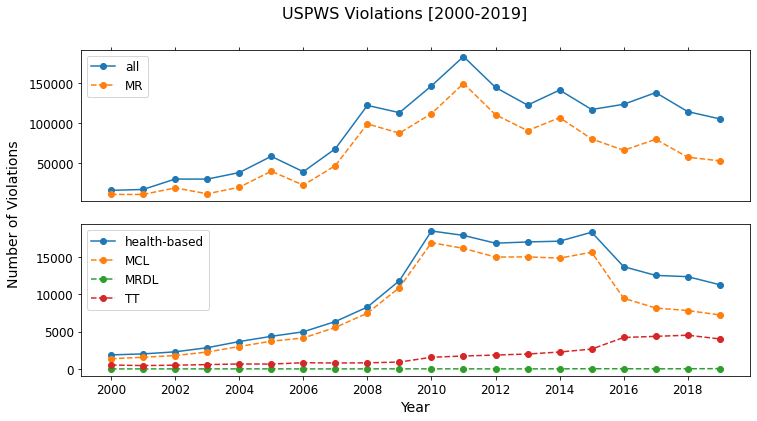

In [32]:
# plot violations and violation categories

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# top plot [all and MR]
ax.plot(viol_yr["YEAR"], viol_yr["VIOL_ALL"],
        "-o", label="all")
ax.plot(viol_yr["YEAR"], viol_yr["VIOL_MR"],
         "--o", label="MR")

ax.legend(loc="upper left", frameon=True)
ax.spines['bottom'].set_visible(True)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # no top tick labels

# bottom plot [health-based - MCL, MRDL, TT]
ax2.plot(viol_yr["YEAR"], viol_yr["VIOL_HLTH"],
         "-o", label="health-based")
ax2.plot(viol_yr["YEAR"], viol_yr["VIOL_MCL"],
         "--o", label="MCL")
ax2.plot(viol_yr["YEAR"], viol_yr["VIOL_MRDL"],
         "--o", label="MRDL")
ax2.plot(viol_yr["YEAR"], viol_yr["VIOL_TT"],
         "--o", label="TT")

ax2.legend(loc="upper left", frameon=True)
#ax2.legend(bbox_to_anchor=(0,0.55,1,0.55), loc="upper left",
#           mode="expand", borderaxespad=0, ncol=4, frameon=False)
ax2.spines['top'].set_visible(True)
ax2.xaxis.tick_bottom()

f.subplots_adjust(hspace=0.15) # break distance
plt.xticks(range(2000,2020,2))
plt.xlabel("Year")
# common ylabel
f.text(0.04, 0.5, 'Number of Violations',
       va='center', rotation='vertical', size=14)
# common title
plt.suptitle("USPWS Violations [2000-2019]");

## 3. Violation trends by year

Cumulative yearly violation spike started in 2008 (almost doubled from 67602 in 2007 to 121773 in 2008) and peaked in 2011 with 182905 violations. They have generally declined since to almost 57% that value in 2019.

The health-based violation spike also started in 2008 but plateaued from 2010 to 2015 (with 17808 violations on average) and have since declined to 64% of that value in 2019.

Potential for further explorations -- elements that can help explain these trends (rules/regulations, specific weather related or outbreak events, socio-economic factors, etc.).

In [33]:
#viol_yr.sort_values(
#    by="VIOL_HLTH", ascending=False)["VIOL_HLTH"][:5].mean() # 17808

In [34]:
#viol_yr[["VIOL_ALL"]].sum() # 1861334
#viol_yr[["VIOL_HLTH"]].sum() # 204514
#int(viol_yr[["VIOL_HLTH"]].sum()) / int(viol_yr[["VIOL_ALL"]].sum()) # 0.110
#viol_yr[["VIOL_MR"]].div(viol_yr.VIOL_ALL, axis=0).describe() # 0.648 +/- 0.121
#viol_yr[["VIOL_HLTH"]].div(viol_yr.VIOL_ALL, axis=0).describe() # 0.108 +/- 0.022
#viol_yr[["VIOL_MCL"]].div(viol_yr.VIOL_HLTH, axis=0).describe() # 0.810 +/- 0.095
#viol_yr[["VIOL_TT"]].div(viol_yr.VIOL_HLTH, axis=0).describe() # 0.189 +/- 0.094
#viol_yr[["VIOL_MRDL"]].div(viol_yr.VIOL_HLTH, axis=0).describe() # 0.00072 +/- 0.0008

## 4. Identify key violation types that contribute to the trends

Based on the 20 years of data, on average, Monitoring and Reporting (**MR**) and health-based violations represent 65$\pm$12% and 11$\pm$2% of all violations, respectively. *Note* the variability of the data indicated by the $\pm$ sign here is the standard deviation.

The Maximum Contaminant Level (**MCL**) and Treatment Technique (**TT**) violations represent 80 $\pm$10% and 19$\pm$9% of health-based violations. Maximum Residual Disinfectant Level (**MRDL**) contstitutes less than 1% of all health-based violations.

In [35]:
#viol["CONTAMINANT_CODE"] # Wanted to dig information on contaminants
# contributing to violations. Couldn't locate mapping for contaminant identifier
# to name (or general identifier). Waiting to hear back from EPA support through
# their contact us link.

### B.7. Group by PWSID

In [36]:
# count of PWS violations grouped by PWS
pws_viol_pws = pws_viol[["PWSID", "VIOLATIONID"]].groupby(
    "PWSID", as_index=False).count()

# rename count column
pws_viol_pws.rename(
    columns={"VIOLATIONID": "VIOL_COUNT"}, inplace=True)

# add PWS name, county, state identifiers
pws_viol_pws = pd.merge(
    pws_viol_pws,
    pws_viol[["PWSID", "PWSNAME", "COUNTYID", "COUNTYNAME",
              "STATE", "POPULATION"]].drop_duplicates(
        subset=["PWSID", "PWSNAME", "COUNTYID", "COUNTYNAME",
                "STATE", "POPULATION"],
        keep="first"),
    on="PWSID", how="left")

# count and add health-based violations dataframe
pws_viol_pws["HLTH_COUNT"] = pws_viol.groupby(
    "PWSID", as_index=False)["VIOL_HLTH"].apply(
    lambda x: x[x == "Y"].count())["VIOL_HLTH"]

# reorder columns
pws_viol_pws = pws_viol_pws[["PWSID", "PWSNAME", "COUNTYNAME",
                             "STATE", "VIOL_COUNT", "HLTH_COUNT",
                             "POPULATION", "COUNTYID"]]
#pws_viol_pws.head(2)

In [37]:
# dataframe sorted by count of all violations
# COUNTYID sliced to drop reduncency
pws_viol_pws.sort_values(by="VIOL_COUNT",
                         ascending=False).iloc[:, :-1]

,PWSID,PWSNAME,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
130175,WV3305536,PIERPOINT WATER,Wyoming,WV,3808,1,88
129698,WV3301040,KANAWHA FALLS COMMUNITY WATER,Fayette,WV,3328,8,55
96482,PA2400148,STOCKTON WATER SYSTEM,Carb,PA,3030,0,85
13649,CT0859071,27 MAPLE DRIVE,Fairfield,CT,2767,0,38
129871,WV3302451,OTOOLE WATER,McDowell,WV,2671,1,24
...,...,...,...,...,...,...,...
77820,NY0611706,"SPRINGS RESTAURANT INC, THE",Chautauqua,NY,1,0,100
77834,NY0611916,HIDDEN VALLEY CAMPGROUND,Chautauqua,NY,1,0,250
77839,NY0615958,PINE VALLEY SR JR HIGH SCHOOL,Cattaraugus,NY,1,0,485
77852,NY0616512,HAFF ACRES FARM,Chautauqua,NY,1,0,25


In [38]:
# dataframe sorted by count of health-based violations
# COUNTYID sliced out to drop reduncency
pws_viol_pws.sort_values(by="HLTH_COUNT",
                         ascending=False).iloc[:, :-1]

,PWSID,PWSNAME,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
112176,TX1540001,CITY OF BRADY WATER SYSTEM,McCulloch,TX,479,426,5371
112053,TX1520005,CITY OF WOLFFORTH,Lubbock,TX,523,396,3600
124815,WI2680238,WAUKESHA WATER UTILITY,Waukesha,WI,290,250,70718
34591,KS2007308,"SEVERY, CITY OF",Elk,KS,247,184,230
113196,TX1870105,TEMPE WSC 1,Polk,TX,292,173,1897
...,...,...,...,...,...,...,...
66338,NC1056019,BURNETTES LANDING,McDowell,NC,5,0,100
66337,NC1056018,NEW HORIZON FELLOWSHIP CHURCH,McDowell,NC,2,0,125
66335,NC1056015,GLENWOOD COUNTRY STORE,NaN,NC,20,0,75
66334,NC1056013,SUNSET POINT S/D,McDowell,NC,10,0,25


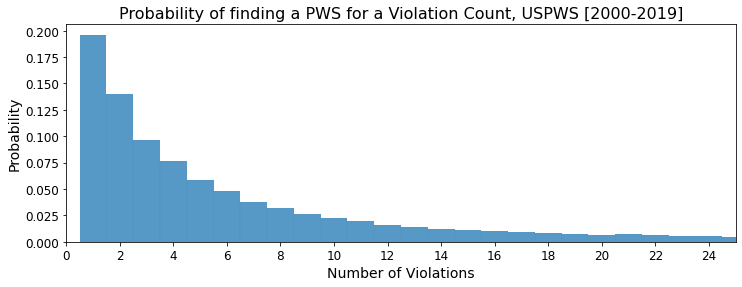

In [39]:
# plot violations by PWS 
plt.figure(figsize=(12,4))
hp = sns.histplot(data=pws_viol_pws, x="VIOL_COUNT",
                  discrete=True, #kde=True,
                  stat="probability")
hp.set(ylim=(0, None), xlim=(0, 25),
      xlabel="Number of Violations",
      ylabel="Probability",
      title="Probability of finding a PWS for a Violation Count, USPWS [2000-2019]",
      xticks=(range(0,26, 2)));

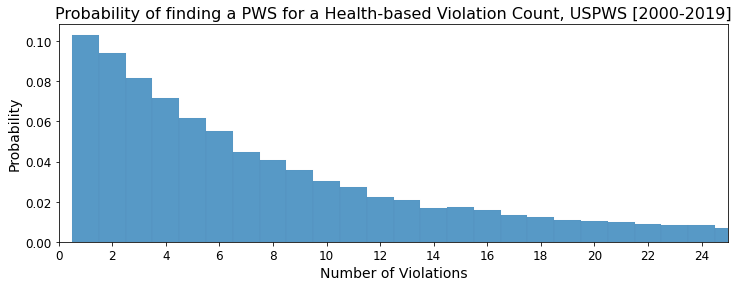

In [40]:
# plot health-based violations by PWS 
plt.figure(figsize=(12,4))
hp = sns.histplot(
    data=pws_viol_pws[pws_viol_pws["HLTH_COUNT"] != 0],
    x="VIOL_COUNT", discrete=True, #kde=True,
    stat="probability")

hp.set(ylim=(0, None), xlim=(0, 25),
      xlabel="Number of Violations",
      ylabel="Probability",
      title="Probability of finding a PWS for a Health-based Violation Count, USPWS [2000-2019]",
      xticks=(range(0,26, 2)));

In [41]:
pws_viol_pws.groupby("STATE", as_index= False)[
    ["VIOL_COUNT", "HLTH_COUNT"]].apply(sum).sort_values(
    by="VIOL_COUNT", ascending=False).head(6)

,STATE,VIOL_COUNT,HLTH_COUNT
36,PA,206217,9844
41,TX,163986,24340
23,MS,149738,1425
32,NY,123477,6293
25,NC,100642,6129
2,AZ,68863,4620


In [42]:
pws_viol_pws.groupby("STATE", as_index= False)[
    ["VIOL_COUNT", "HLTH_COUNT"]].apply(sum).sort_values(
    by="HLTH_COUNT", ascending=False).head(4)

,STATE,VIOL_COUNT,HLTH_COUNT
41,TX,163986,24340
3,CA,52735,21480
34,OK,46810,12443
36,PA,206217,9844


## 5. Violation distributions by PWS

Based on the 20 years of data, there were 24 PWS's with cumulative violations greater than 1000 and 55 PWS's with health-based violations greater than 100. Pierpoint Water from Wyoming, WV had the most violations (3,808).

During the years 2000-2019, 5 states (PA, TX, MS, NY, and NC) had more than 100,000 violations while 3 states (TX, CA, and OK) had health-based violations > 10,000.

### B.8. Load shapefile and prepare dataframe for choropleth map plot

In [43]:
# read state shapefiles downloaded from US census ...
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
us_state = geopandas.read_file(
    "./data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

# keep only mainland
us_state = us_state[us_state["STUSPS"].isin(usps_st)]

print(f"us_state shape: {us_state.shape}")
us_state.head(2)

us_state shape: (49, 10)


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [44]:
# read county shapefiles downloaded from US census ...
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
us_county = geopandas.read_file(
    "./data/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")
us_county = us_county[us_county["STATEFP"].isin(list(FIPS.keys()))] 

print(f"us_county shape: {us_county.shape}")
us_county.head(2)

us_county shape: (3108, 10)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."


In [45]:
# keep only GEOID (County id) and geometry columns
us_county.drop(["STATEFP", "COUNTYFP", "COUNTYNS",
                  "AFFGEOID", "NAME", "LSAD", "ALAND",
                  "AWATER"], axis=1, inplace=True)

### B.9. Group by County

## PWS's without violations [2000-2019]

In [46]:
# violationless pws grouped by county
pws_clean_county = pws_clean[["PWSID", "COUNTYID"]].groupby(
    "COUNTYID", as_index=False).count()

# rename column
pws_clean_county.rename(
    columns={"PWSID": "PWS_COUNT"}, inplace=True) 

# add County name and State identifier columns
pws_clean_county = pd.merge(
    pws_clean_county,
    pws_clean[["COUNTYID", "COUNTYNAME", "STATE"]].drop_duplicates(
        subset=["COUNTYID"], keep="first"),
    on="COUNTYID", how="left")

# add population served column
pws_clean_county["POPULATION"] = pws_clean[
    ["COUNTYID", "POPULATION"]].groupby(
    "COUNTYID", as_index=False).sum()["POPULATION"]

# merge with usa_county geodataframe
pws_clean_county = pd.merge(
    pws_clean_county, us_county[["GEOID", "geometry"]],
    left_on="COUNTYID", right_on="GEOID", how="left")

# drop redundant column
pws_clean_county.drop(["GEOID"], axis=1, inplace=True)

# reorder columns
pws_clean_county = pws_clean_county[
    ["COUNTYID", "COUNTYNAME", "STATE", "PWS_COUNT",
     "POPULATION", "geometry"]]

# convert back to geopandas geodataframe object
pws_clean_county = geopandas.GeoDataFrame(pws_clean_county)

# sorted dataframe by PWS_COUNT
pws_clean_county.sort_values(
    by="PWS_COUNT", ascending=False).iloc[:, :-1]

,COUNTYID,COUNTYNAME,STATE,PWS_COUNT,POPULATION
538,17031,Cook,IL,3306,1708480
2449,48201,Harris,TX,2136,1372171
571,17097,Lake,IL,1862,409474
311,12057,Hillsborough,FL,1670,763338
274,09003,Hartford,CT,1458,44862
...,...,...,...,...,...
2333,47141,Putnam,TN,1,50
369,13037,Calh,GA,1,150
1495,30059,Meagher,MI,1,35
978,21171,Monroe,KY,1,6


**Two counties from Illinois (Cook (first) and Lake (third)) made into the top five counties in the mainland US to have the most PWS's without reported violations** in the first 20 years of this millenia. There were 16 counties with 1000 or more violationless PWS's.

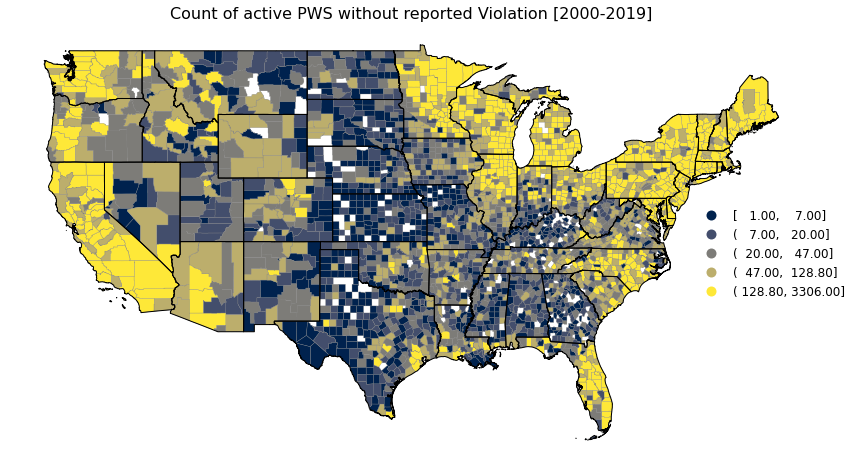

In [47]:
# plot count of violationless PWS's by county
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, edgecolor="black", linewidth=1);
p = pws_clean_county.plot(edgecolor="grey", linewidth=0.3,
    ax=ax, column="PWS_COUNT", scheme='Quantiles',
    cmap="cividis", # summer, viridis, cividis
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.55, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Count of active PWS without reported Violation [2000-2019]");

The north-eastern states by the great lakes, the majority of east-atlantic states (with the exception of Georgia, South Carolina, and Virginia), as well as the pacific coast states in the west had (counties with) the **largest concentration of public water systems without reported violations in the 20 year period (2000-2019)**.

### B.10. Merge PWS Violation table with county geodataframe

In [48]:
# merge pws_viol_pws with usa_county geodataframe
pws_viol_pws = pd.merge(
    pws_viol_pws, us_county[["GEOID", "geometry"]],
    left_on="COUNTYID", right_on="GEOID", how="left")

# drop redundant column
pws_viol_pws.drop(["GEOID"], axis=1, inplace=True)

# convert back to geopandas geodataframe object
pws_viol_pws = geopandas.GeoDataFrame(pws_viol_pws)

#pws_viol_pws.head(2)

## 6. Violation counts by county

In [49]:
# violation counts by county
pws_viol_county = pws_viol_pws.groupby(
    ["COUNTYID", "COUNTYNAME"], as_index=False)[
    ["VIOL_COUNT", "HLTH_COUNT", "POPULATION"]].apply(sum)

# add County name and State identifier columns
pws_viol_county = pd.merge(
    pws_viol_county,
    pws_viol_pws[["COUNTYID", "STATE", "geometry"]].drop_duplicates(
        subset=["COUNTYID"], keep="first"),
    on="COUNTYID", how="left")

# reorder columns
pws_viol_county = pws_viol_county[
    ["COUNTYNAME", "STATE", "VIOL_COUNT", "HLTH_COUNT",
     "POPULATION", "COUNTYID", "geometry"]]

In [50]:
# sorted by violation count
pws_viol_county.sort_values(by="VIOL_COUNT", ascending=False).iloc[:, :-2]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
2468,Harris,TX,19410,1067,4679821
1735,Orange,NY,15401,379,368506
272,Fairfield,CT,14758,882,856065
1713,Dutchess,NY,12548,919,250788
2860,Wyoming,WV,11805,67,19244
...,...,...,...,...,...
2754,Hampton ci,VA,1,0,600
2756,Lynchburg ci,VA,1,1,168
2365,Weakle,TN,1,0,50
794,Osceola,IA,1,0,2060


**Harris county from Texas is a potential for further exploration** as it appears to lead both in the most number of violationless PWS's (second after Cook, IL) as well the county with the most violations -- role of socio economic inequalities?

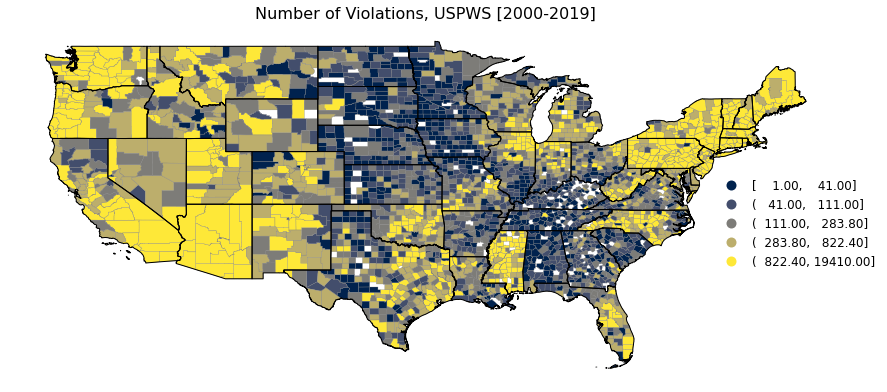

In [51]:
# plot cumulative violation counts by county
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, edgecolor="black", linewidth=1);
p = pws_viol_county.plot(edgecolor="grey", linewidth=0.3,
    ax=ax, column="VIOL_COUNT", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.55, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Number of Violations, USPWS [2000-2019]");

Most of the east and west coast state counties show high number of violations. These counties are likely to be heavily populated. Will check back with population normalized violations a little later.

Most counties in Mississippi show large violation counts. Lets check how the health-based violation counts fare here in the next plot.

In [52]:
# sorted by health-based violation counts
pws_viol_county.sort_values(by="HLTH_COUNT", ascending=False).iloc[:, :-2]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
159,Fres,CA,4955,2633,989111
164,Ker,CA,4462,2508,493498
2518,Lubbock,TX,8414,2288,297052
203,Tulare,CA,3223,1801,204707
176,Montere,CA,2114,1255,171969
...,...,...,...,...,...
432,Lanier,GA,10,0,390
2750,Bristol ci,VA,2,0,20000
2751,Charlottesville ci,VA,3,0,85
2754,Hampton ci,VA,1,0,600


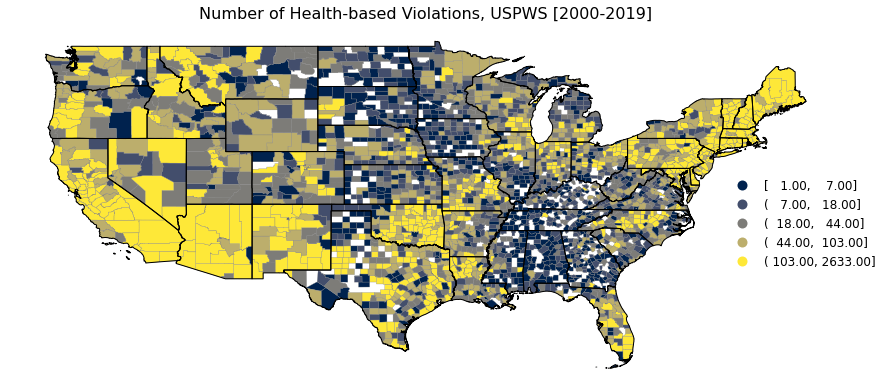

In [53]:
# plot cumulative health-based violation counts
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, color="black", linewidth=1);
p = pws_viol_county[pws_viol_county["HLTH_COUNT"] != 0].plot(
    edgecolor="grey", linewidth=0.3,
    ax=ax, column="HLTH_COUNT", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.55, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Number of Health-based Violations, USPWS [2000-2019]");

This plot shows that the high number of violation counts in Mississippi weren't health-based. Counties in eastern Texas show high counts for both health-based as well as non-health-based violations.

## 7. Number of people affected by violations

In [54]:
# sorted by population affected by violations
pws_viol_county.sort_values(
    by="POPULATION", ascending=False).iloc[:, :-2]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
1740,Queens,NY,567,18,8275876
168,Los Angeles,CA,2402,484,6058237
2468,Harris,TX,19410,1067,4679821
549,Cook,IL,8874,202,4614918
70,Maricopa,AZ,11792,1033,4586605
...,...,...,...,...,...
2921,Taylor,WI,1,1,25
489,Honolul,WA,74,1,20
1901,Stark,ND,1,0,15
996,Owe,KY,3,0,0


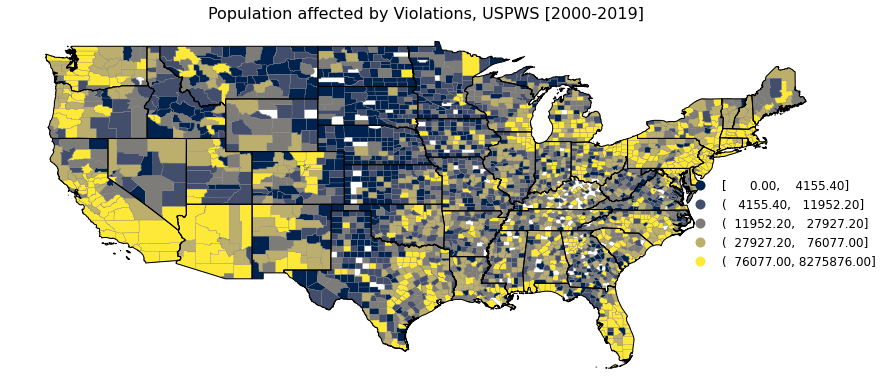

In [55]:
# plot cumulative population affected by violations
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, color="black", linewidth=1);
p = pws_viol_county.plot(
    edgecolor="grey", linewidth=0.3,
    ax=ax, column="POPULATION", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.55, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Population affected by Violations, USPWS [2000-2019]");

In [56]:
# Percent of health-based violations compare to all violations
pws_viol_county["HLTHPRCNT"] = round(100*pws_viol_county[
    "HLTH_COUNT"].div(pws_viol_county["VIOL_COUNT"]), 1)

pws_viol_county.sort_values(
    by="HLTHPRCNT", ascending=False).iloc[:, [0,1, 2, 3, 4, 7]]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT
1279,Todd,MN,2,2,325,100.0
2756,Lynchburg ci,VA,1,1,168,100.0
816,Worth,IA,6,6,44,100.0
1280,Traverse,MN,3,3,30,100.0
2921,Taylor,WI,1,1,25,100.0
...,...,...,...,...,...,...
352,Bac,GA,14,0,7526,0.0
1270,Rock,MN,2,0,982,0.0
484,Whitfield,GA,12,0,99863,0.0
488,Worth,GA,13,0,947,0.0


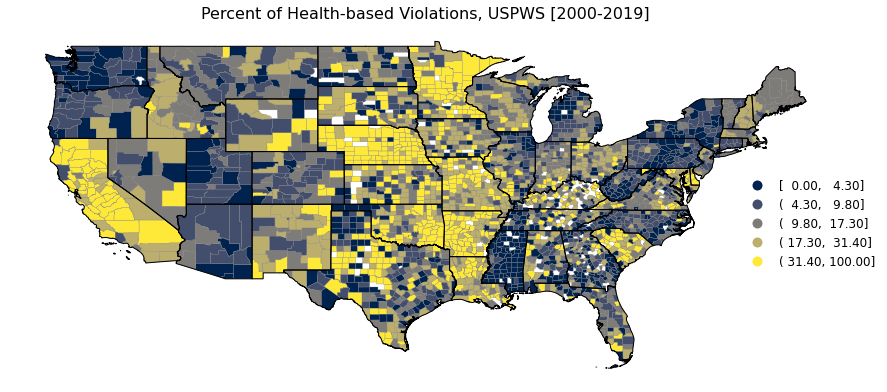

In [57]:
# plot health-based violation percentage of all violations
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, color="black", linewidth=1);
p = pws_viol_county.plot(
    edgecolor="grey", linewidth=0.3,
    ax=ax, column="HLTHPRCNT", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.55, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Percent of Health-based Violations, USPWS [2000-2019]");

The midwest region shows higher concentration of counties with higher percent of health-based violations.

California had consistently high health-based and overall violations. **Percent of health-based violations variy greatly.** In the future, it would be interesting to examine elements that play a role here (tighter/less-tight regulations or other factors?).

## Population affected by health-based violations [2000-2019]

In [58]:
# Population affected by health-bases violations
pws_viol_county["HLTH_POPL"] = pws_viol_county["POPULATION"].mul(
    pws_viol_county["HLTHPRCNT"]).div(100).astype(int)

pws_viol_county.sort_values(
    by="HLTH_POPL", ascending=False).iloc[:, [0,1, 2, 3, 4, 7, 8]]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT,HLTH_POPL
168,Los Angeles,CA,2402,484,6058237,20.1,1217705
192,Santa Clara,CA,939,279,2377708,29.7,706179
159,Fres,CA,4955,2633,989111,53.1,525217
1087,Baltimore,MD,731,221,1644742,30.2,496712
186,San Dieg,CA,3107,736,2040710,23.7,483648
...,...,...,...,...,...,...,...
2517,Loving,TX,35,0,165,0.0,0
1809,Hyde,NC,26,0,6416,0.0,0
400,Elber,GA,90,0,12518,0.0,0
2283,Walworth,SD,58,0,3635,0.0,0


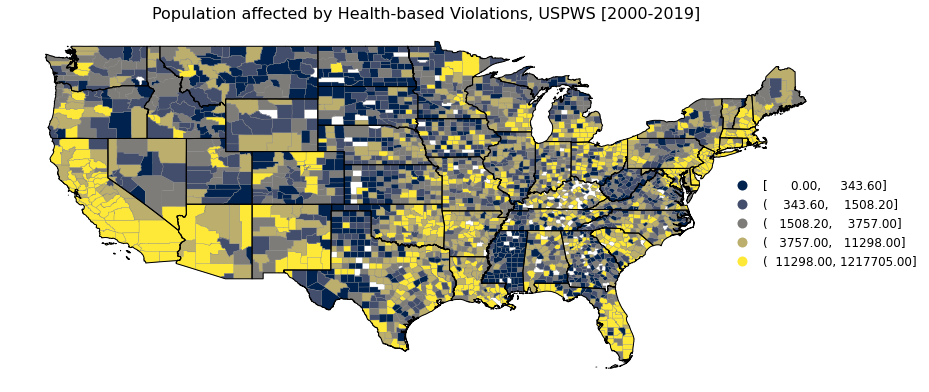

In [59]:
# plot cumulative population affected by health-based violations
f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, color="black", linewidth=1);
p = pws_viol_county.plot(
    edgecolor="grey", linewidth=0.3,
    ax=ax, column="HLTH_POPL", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.6, 0.1, 0.5, 0.5),
                 "frameon": False});
p.axis("off");
ax.set_title("Population affected by Health-based Violations, USPWS [2000-2019]");

In [60]:
# Counties with average yearly population ...
# (affected by health-based violations) >= 50k

print("Counties with avg. yearly population",
      "(affected by health-based violation) >= 10,000:")

pws_viol_county[pws_viol_county["HLTH_POPL"].div(
     len(range(2000,2019+1))) >= 10000].sort_values(
    by="HLTH_POPL", ascending=False).iloc[:, [0,1, 2, 3, 4, 7, 8]]

Counties with avg. yearly population (affected by health-based violation) >= 10,000:


,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT,HLTH_POPL
168,Los Angeles,CA,2402,484,6058237,20.1,1217705
192,Santa Clara,CA,939,279,2377708,29.7,706179
159,Fres,CA,4955,2633,989111,53.1,525217
1087,Baltimore,MD,731,221,1644742,30.2,496712
186,San Dieg,CA,3107,736,2040710,23.7,483648
70,Maricopa,AZ,11792,1033,4586605,8.8,403621
1933,Frankli,VA,870,234,1330287,26.9,357847
185,San Bernardi,CA,1783,715,835198,40.1,334914
2587,Travis,TX,6343,1115,1791879,17.6,315370
182,Riverside,CA,1936,351,1740804,18.1,315085


The Los Angeles county, CA was the only county in the mainland US with average yearly health-based violation affected population >= 50,000. There were 22 counties where this was true for population >= 10,000.**

## Violation counts normalized by Population affected

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:856: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mapclassify/classifiers.py:887: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


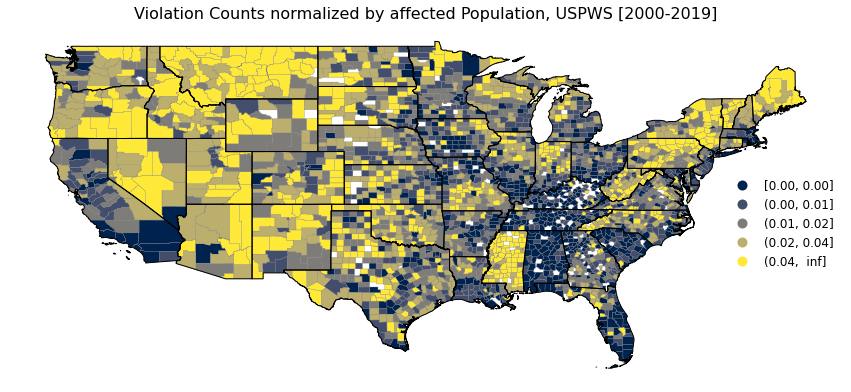

In [61]:
# count of violations (by county) normalized by population affected
pws_viol_county["VIOL_POPLNORM"] = pws_viol_county[
        "VIOL_COUNT"].div(pws_viol_county["POPULATION"])

f, ax = plt.subplots(1)

us_state.boundary.plot(ax=ax, color="black", linewidth=1);
p = pws_viol_county.plot(edgecolor="grey", linewidth=0.3,
    ax=ax, column="VIOL_POPLNORM", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.5, 0.1, 0.5, 0.5),
                 "frameon": False});

p.axis("off");
ax.set_title("Violation Counts normalized by affected Population, USPWS [2000-2019]");

Infinity appears because there are a few counties with no health-based violations.

In [68]:
pws_viol_county.iloc[:, [0, 1, 2, 3, 4, 7, 8, 9]]
#pws_viol_county

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT,HLTH_POPL,VIOL_POPLNORM
0,Autauga,AL,63,2,66550,3.2,2129,0.000947
1,Baldwi,AL,486,10,191741,2.1,4026,0.002535
2,Barbour,AL,62,6,29548,9.7,2866,0.002098
3,Bibb,AL,3,0,22476,0.0,0,0.000133
4,Bl,AL,68,1,76621,1.5,1149,0.000887
...,...,...,...,...,...,...,...,...
2949,Sherida,WY,128,25,21906,19.5,4271,0.005843
2950,Sublette,WY,217,16,5032,7.4,372,0.043124
2951,Sweetwater,WY,441,102,38566,23.1,8908,0.011435
2952,Te,WY,774,72,21041,9.3,1956,0.036785


## Health-based violations in New York, USPWS [2000-2019]

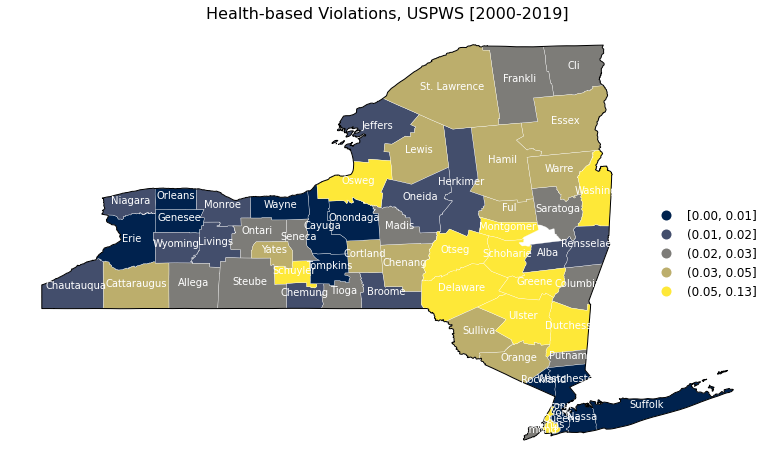

In [63]:
# plot cumulative health-based violations for NY

f, ax = plt.subplots(1)

# add countyname label
pws_viol_county[pws_viol_county["STATE"] == "NY"].apply(
    lambda x: ax.text(
        x=x.geometry.centroid.x,
        y=x.geometry.centroid.y,
        s=x.COUNTYNAME,
        ha='center', fontsize=10,
        color="white"), axis=1);

us_state[us_state["STUSPS"] == "NY"].boundary.plot(
    ax=ax, color="black", linewidth=1);

p = pws_viol_county[pws_viol_county["STATE"] == "NY"].plot(
    edgecolor="white", linewidth=0.3,
    ax=ax, column="VIOL_POPLNORM", scheme='Quantiles',
    cmap="cividis",
    legend=True,
    legend_kwds={"loc": "best",
                 "bbox_to_anchor": (0.5, 0.1, 0.5, 0.5),
                 "frameon": False});

p.axis("off");
ax.set_title("Health-based Violations, USPWS [2000-2019]");

In [64]:
# erie county NY violations
pws_viol_county[
    (pws_viol_county["STATE"] == "NY") & 
    (pws_viol_county["COUNTYNAME"] == "Erie")].iloc[:, [0,1,2,3,4,7,8,9]]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT,HLTH_POPL,VIOL_POPLNORM
1714,Erie,NY,2258,66,618071,2.9,17924,0.003653


In [65]:
# erie county NY Health-based violations (percent of all violations)
pws_viol_county[
    (pws_viol_county["STATE"] == "NY")].sort_values(
    by="HLTHPRCNT", ascending=False).iloc[:10, [0,1,2,3,4,7,8,9]]

,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION,HLTHPRCNT,HLTH_POPL,VIOL_POPLNORM
1739,Putnam,NY,1048,521,50187,49.7,24942,0.020882
1718,Genesee,NY,147,37,44829,25.2,11296,0.003279
1760,Wyoming,NY,131,31,6499,23.7,1540,0.020157
1701,Allega,NY,1342,177,54649,13.2,7213,0.024557
1751,Suffolk,NY,1336,169,1324871,12.6,166933,0.001008
1722,Jeffers,NY,1780,203,119083,11.4,13575,0.014948
1705,Cayuga,NY,1119,127,126765,11.3,14324,0.008827
1733,Onondaga,NY,1162,119,279877,10.2,28547,0.004152
1716,Frankli,NY,569,57,21675,10.0,2167,0.026251
1743,Rockland,NY,1300,124,317904,9.5,30200,0.004089


In [66]:
# ECWA
pws_viol_pws[
    (pws_viol_pws["STATE"] == "NY") & 
    (pws_viol_pws["COUNTYNAME"] == "Erie") &
    (pws_viol_pws["PWSNAME"].str.slice(stop=4) == "ECWA")].sort_values(
    by="POPULATION", ascending=False).iloc[:50, [1, 2, 3, 4, 5, 6]]

,PWSNAME,COUNTYNAME,STATE,VIOL_COUNT,HLTH_COUNT,POPULATION
79518,ECWA DIRECT,Erie,NY,2,0,248000
79519,ECWA EVANS,Erie,NY,5,1,12417
79527,ECWA WILLIAMSVILLE,Erie,NY,13,0,5573
79571,ECWA NEWSTEAD,Erie,NY,1,0,5319


In [67]:
# ECWA WILLIAMSVILLE
pws_viol[
    (pws_viol["STATE"] == "NY") & 
    (pws_viol["COUNTYNAME"] == "Erie") &
    (pws_viol["PWSNAME"] == "ECWA WILLIAMSVILLE")]

,PWSID,PWSNAME,VIOLATIONID,CATEGORY,YEAR,VIOL_HLTH,COUNTYID,COUNTYNAME,STATE,ZIPCODE,POPULATION
2062887,NY1400541,ECWA WILLIAMSVILLE,216,MR,2011,N,36029,Erie,NY,14203,5573
2062888,NY1400541,ECWA WILLIAMSVILLE,219,MR,2013,N,36029,Erie,NY,14203,5573
2062889,NY1400541,ECWA WILLIAMSVILLE,217,MR,2013,N,36029,Erie,NY,14203,5573
2062890,NY1400541,ECWA WILLIAMSVILLE,210,MR,2012,N,36029,Erie,NY,14203,5573
2062891,NY1400541,ECWA WILLIAMSVILLE,218,MR,2013,N,36029,Erie,NY,14203,5573
2062892,NY1400541,ECWA WILLIAMSVILLE,213,MR,2012,N,36029,Erie,NY,14203,5573
2062893,NY1400541,ECWA WILLIAMSVILLE,209,MR,2009,N,36029,Erie,NY,14203,5573
2062894,NY1400541,ECWA WILLIAMSVILLE,220,MR,2013,N,36029,Erie,NY,14203,5573
2062895,NY1400541,ECWA WILLIAMSVILLE,211,MR,2012,N,36029,Erie,NY,14203,5573
2062896,NY1400541,ECWA WILLIAMSVILLE,215,MR,2012,N,36029,Erie,NY,14203,5573


ECWA had Monitoring and Reporting (MR) violations in the years 2003, 2009, 2011, 2012, and 2013.